# **Preprocessing**

In preprocessing the data, the following steps are taken:

> * Prepare packages and setup  
> * Load in the data  
> * Tidy the data and store metadata  
> * Inspect data with various metrics  
> * Inspect data with visualisations 
> * Select locations
> * Select timeframe
> * Feature engineering
> * Perform train-validation-test-split  
> * Normalisation  
> * Create big combined normalised dataframe

## **IMPORTANT**
Before preprocessing, download the following datasets into `data/raw/`:

Weather Data
- **Station**: De Bilt (S260)
- **Source**: KNMI
- **Method**: Run `src/pipeline/knmy.ipynb` (automated via [KNMY repo](https://github.com/KNMI/knmy))

Pollution Data
- **Stations**: Tuindorp (NL10636), Breukelen (NL10641)
- **Pollutant**: NO₂
- **Source**: [RIVM Luchtmeetnet](https://data.rivm.nl/data/luchtmeetnet/Vastgesteld-jaar/)
- **Method**: Manually download 2016-2023 data from the source in "breed formaat" to `data/raw`


### **Prepare packages and setup**

In [3]:
from pipeline import read_meteo_csv_from_data_raw
from pipeline import read_four_contaminants
from pipeline import get_metadata
from pipeline import tidy_raw_contaminant_data
from pipeline import tidy_raw_meteo_data
from pipeline import print_aggegrated_sensor_metrics
from pipeline import subset_sensors
from pipeline import perform_data_split
from pipeline import perform_data_split_without_train
from pipeline import print_split_ratios
from pipeline import calc_combined_min_max_params
from pipeline import normalise_linear
from pipeline import print_pollutant_extremes
from pipeline import export_minmax
from pipeline import plot_distributions_KDE
from pipeline import concat_frames_horizontally
from pipeline import delete_timezone_from_index
from pipeline import assert_equal_shape
from pipeline import assert_equal_index
from pipeline import assert_no_NaNs
from pipeline import assert_range

In [4]:
SUBSET_MONTHS = bool(1)                 # If true, only the months specified in the list below will be
                                        # used for the training, validation and testing set
START_MON = '08'                        # starting month for the data
END_MON = '12'                          # ending month for the data

# Days used for the training, validation and testing splits
days_vali = 21
days_test = 21

days_vali_final_yrs = 63
days_test_final_yrs = 63

# ============================================================================+

# # Sensor locations in the case of Utrecht area:
# DE_BILT = 'S260'                        # starting (and only used) location for meteorological data
# TUINDORP = 'NL10636'                    # starting location for contamination data
# BREUKELEN = 'NL10641'                   # 'goal' location for contamination data
# sensors_1D = [TUINDORP, BREUKELEN]

# Sensors around Amsterdam Schiphol:

HOOFDDORP = 'NL49564'
BADHOEVEDORP = 'NL49561'
OUDEMEER = 'NL49565'
SCHIPOL = 'S240'
sensors_1D = [HOOFDDORP, BADHOEVEDORP, OUDEMEER]
CITY = 'Amsterdam'


# =============================================================================

pollutants = ['NO2'] # adjustable for 'NO2', 'PM10', 'PM25', 'O3'
selected_weather = ['T', 'TD', 'DD', 'FH', 'P', 'SQ', 'FF', 'FX'] # features selected from corr matrix, plus 'FF' and 'FX'

# Define the years for the dataset
years = [2017, 2018, 2020, 2021, 2022, 2023] # adjustable for 2017, 2018, 2020, 2021, 2022, 2023
# years = [2017]

# At multiple locations, a sys.exit() can be used to halt the script

LOG = True

### **Load in the data**

In [5]:
# Explicit variable declaration
df_NO2_2017_raw = None
df_NO2_2017_tidy = None
df_PM25_2017_raw = None
df_PM25_2017_tidy = None
df_PM10_2017_raw = None
df_PM10_2017_tidy = None
df_O3_2017_raw = None
df_O3_2017_tidy = None
df_meteo_2017_raw = None

df_NO2_2018_raw = None
df_NO2_2018_tidy = None
df_PM25_2018_raw = None
df_PM25_2018_tidy = None
df_PM10_2018_raw = None
df_PM10_2018_tidy = None
df_O3_2018_raw = None
df_O3_2018_tidy = None
df_meteo_2018_raw = None

df_NO2_2020_raw = None
df_NO2_2020_tidy = None
df_PM25_2020_raw = None
df_PM25_2020_tidy = None
df_PM10_2020_raw = None
df_PM10_2020_tidy = None
df_O3_2020_raw = None
df_O3_2020_tidy = None
df_meteo_2020_raw = None

df_NO2_2021_raw = None
df_NO2_2021_tidy = None
df_PM25_2021_raw = None
df_PM25_2021_tidy = None
df_PM10_2021_raw = None
df_PM10_2021_tidy = None
df_O3_2021_raw = None
df_O3_2021_tidy = None
df_meteo_2021_raw = None

df_NO2_2022_raw = None
df_NO2_2022_tidy = None
df_PM25_2022_raw = None
df_PM25_2022_tidy = None
df_PM10_2022_raw = None
df_PM10_2022_tidy = None
df_O3_2022_raw = None
df_O3_2022_tidy = None
df_meteo_2022_raw = None

df_NO2_2023_raw = None
df_NO2_2023_tidy = None
df_PM25_2023_raw = None
df_PM25_2023_tidy = None
df_PM10_2023_raw = None
df_PM10_2023_tidy = None
df_O3_2023_raw = None
df_O3_2023_tidy = None
df_meteo_2023_raw = None


In [6]:
# Loading raw data
for year in years:
    raw_data = read_four_contaminants(year, pollutants)
    for pollutant, data in zip(pollutants, raw_data):
        globals()[f'df_{pollutant}_{year}_raw'] = data

In [7]:
# Loading meteorological data
for year in years:
    globals()[f'df_meteo_{year}_raw'] = read_meteo_csv_from_data_raw(year, CITY)

In [8]:
df_NO2_2018_raw

,component,matrix,meetduur,eenheid,begindatumtijd,einddatumtijd,NL01485_NO2_lucht,NL01487_NO2_lucht,NL01488_NO2_lucht,NL01489_NO2_lucht,...,NL49704_NO2_lucht,NL50002_NO2_lucht,NL50003_NO2_lucht,NL50004_NO2_lucht,NL53001_NO2_lucht,NL53004_NO2_lucht,NL53015_NO2_lucht,NL53016_NO2_lucht,NL53020_NO2_lucht,NL54004_NO2_lucht
0,NO2,lucht,uur,µg/m³,2018-01-01T00:00:00+01:00,2018-01-01T01:00:00+01:00,10.3,14.7,26.7,10.3,...,8.8,14.3,11.1,8.6,12.0,23.9,9.0,11.8,1.7,15.4
1,NO2,lucht,uur,µg/m³,2018-01-01T01:00:00+01:00,2018-01-01T02:00:00+01:00,4.4,9.6,14.3,10.7,...,16.4,12.7,8.6,4.5,9.0,20.6,4.1,3.8,1.3,10.1
2,NO2,lucht,uur,µg/m³,2018-01-01T02:00:00+01:00,2018-01-01T03:00:00+01:00,3.1,7.6,9.7,9.0,...,9.0,20.4,5.8,3.5,13.0,19.7,3.5,2.5,1.1,6.3
3,NO2,lucht,uur,µg/m³,2018-01-01T03:00:00+01:00,2018-01-01T04:00:00+01:00,2.7,10.1,8.2,5.3,...,5.0,25.1,5.5,3.3,7.0,25.4,4.3,2.5,1.1,5.8
4,NO2,lucht,uur,µg/m³,2018-01-01T04:00:00+01:00,2018-01-01T05:00:00+01:00,2.3,7.4,7.6,4.8,...,2.9,34.7,4.9,4.5,26.0,26.6,4.0,2.7,1.4,6.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,NO2,lucht,uur,µg/m³,2018-12-31T19:00:00+01:00,2018-12-31T20:00:00+01:00,9.0,36.1,31.3,26.5,...,20.9,16.1,16.7,25.0,35.0,14.7,9.8,8.9,6.1,41.2
8756,NO2,lucht,uur,µg/m³,2018-12-31T20:00:00+01:00,2018-12-31T21:00:00+01:00,8.2,20.2,18.7,26.5,...,33.1,17.4,17.2,27.3,28.0,10.1,6.5,6.1,5.9,37.3
8757,NO2,lucht,uur,µg/m³,2018-12-31T21:00:00+01:00,2018-12-31T22:00:00+01:00,9.4,27.5,21.6,24.4,...,14.7,20.0,18.5,23.9,12.0,11.9,5.8,5.4,6.2,13.6
8758,NO2,lucht,uur,µg/m³,2018-12-31T22:00:00+01:00,2018-12-31T23:00:00+01:00,9.0,30.9,25.6,22.5,...,12.2,24.2,30.0,19.7,15.0,19.8,7.0,6.5,6.7,11.3


In [9]:
df_NO2_2017_raw

,component,matrix,meetduur,eenheid,begindatumtijd,einddatumtijd,NL01485_NO2_lucht,NL01487_NO2_lucht,NL01488_NO2_lucht,NL01489_NO2_lucht,...,NL49704_NO2_lucht,NL50002_NO2_lucht,NL50003_NO2_lucht,NL50004_NO2_lucht,NL53001_NO2_lucht,NL53004_NO2_lucht,NL53015_NO2_lucht,NL53016_NO2_lucht,NL53020_NO2_lucht,NL54004_NO2_lucht
0,NO2,lucht,uur,µg/m³,2017-01-01T00:00:00+01:00,2017-01-01T01:00:00+01:00,38.2,37.1,33.4,33.4,...,43.0,39.3,35.0,30.684,40.0,31.8,41.8,36.3,39.1,39.5
1,NO2,lucht,uur,µg/m³,2017-01-01T01:00:00+01:00,2017-01-01T02:00:00+01:00,37.8,35.9,30.8,38.8,...,51.2,33.9,28.7,25.984,35.0,30.6,40.4,34.7,37.4,40.9
2,NO2,lucht,uur,µg/m³,2017-01-01T02:00:00+01:00,2017-01-01T03:00:00+01:00,36.9,34.0,31.1,36.3,...,48.6,34.5,27.8,34.184,38.0,30.9,38.5,33.0,34.5,43.4
3,NO2,lucht,uur,µg/m³,2017-01-01T03:00:00+01:00,2017-01-01T04:00:00+01:00,36.5,32.1,28.1,31.1,...,42.0,39.9,18.4,36.285,40.0,27.4,36.2,32.4,33.0,37.0
4,NO2,lucht,uur,µg/m³,2017-01-01T04:00:00+01:00,2017-01-01T05:00:00+01:00,24.8,24.4,21.8,26.2,...,42.9,32.9,30.9,35.585,39.0,29.3,36.2,33.8,34.1,33.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,NO2,lucht,uur,µg/m³,2017-12-31T19:00:00+01:00,2017-12-31T20:00:00+01:00,9.4,22.9,15.3,19.5,...,20.7,5.1,16.9,4.300,19.0,33.1,10.0,4.7,2.4,7.1
8756,NO2,lucht,uur,µg/m³,2017-12-31T20:00:00+01:00,2017-12-31T21:00:00+01:00,7.1,13.0,12.4,17.6,...,7.4,4.2,12.7,5.100,15.0,29.1,5.8,4.3,1.7,8.5
8757,NO2,lucht,uur,µg/m³,2017-12-31T21:00:00+01:00,2017-12-31T22:00:00+01:00,6.3,11.7,11.3,12.4,...,8.9,12.3,7.5,5.600,18.0,23.0,5.7,3.4,1.9,7.6
8758,NO2,lucht,uur,µg/m³,2017-12-31T22:00:00+01:00,2017-12-31T23:00:00+01:00,5.3,8.8,8.4,9.6,...,9.9,6.7,11.2,3.700,20.0,24.5,4.4,2.7,1.7,8.1


In [10]:
df_meteo_2017_raw

,STN,YYYYMMDD,HH,DD,FH,FF,FX,T,T10N,TD,...,VV,N,U,WW,IX,M,R,S,O,Y
0,240,20170701,1,270,50,30,70,142,NaN,137,...,50,8,96,52.0,7,0,1,0,0,0
1,240,20170701,2,310,30,30,60,142,NaN,136,...,61,8,96,51.0,7,0,1,0,0,0
2,240,20170701,3,290,30,30,60,144,NaN,138,...,61,8,96,51.0,7,0,1,0,0,0
3,240,20170701,4,280,30,30,50,147,NaN,143,...,65,8,97,57.0,7,0,1,0,0,0
4,240,20170701,5,330,40,50,70,151,NaN,142,...,60,8,94,61.0,7,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4411,240,20171231,20,250,80,110,140,86,NaN,71,...,59,8,90,62.0,7,0,1,0,0,0
4412,240,20171231,21,230,80,80,150,89,NaN,71,...,70,8,88,23.0,7,0,1,0,0,0
4413,240,20171231,22,220,100,100,160,91,NaN,66,...,63,8,84,NaN,5,0,0,0,0,0
4414,240,20171231,23,210,100,90,140,81,NaN,50,...,66,6,80,NaN,5,0,0,0,0,0


In [11]:
df_meteo_2018_raw

,STN,YYYYMMDD,HH,DD,FH,FF,FX,T,T10N,TD,...,VV,N,U,WW,IX,M,R,S,O,Y
0,240,20180701,1,80,70,80,110,180,NaN,59,...,83,0,45,NaN,5,0,0,0,0,0
1,240,20180701,2,80,60,60,100,175,NaN,56,...,83,0,45,NaN,5,0,0,0,0,0
2,240,20180701,3,90,60,70,90,168,NaN,54,...,83,0,46,NaN,5,0,0,0,0,0
3,240,20180701,4,90,60,60,100,169,NaN,53,...,83,0,46,NaN,5,0,0,0,0,0
4,240,20180701,5,90,70,70,100,176,NaN,58,...,83,0,45,NaN,5,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4411,240,20181231,20,240,50,50,80,84,NaN,71,...,57,8,91,51.0,7,0,1,0,0,0
4412,240,20181231,21,250,60,50,80,84,NaN,73,...,63,8,93,22.0,7,0,1,0,0,0
4413,240,20181231,22,270,60,60,80,85,NaN,57,...,70,8,82,NaN,5,0,0,0,0,0
4414,240,20181231,23,260,60,60,110,86,NaN,59,...,70,8,83,NaN,5,0,0,0,0,0


In [12]:
if LOG:
    print('(1/8): Data read successfully')

(1/8): Data read successfully


### **Tidy Pollutants data**
Certain days which might affect pollutants are removed

Also only made it start from August (START_MON) until December (END_MON)

In [13]:
# Metadata extraction
for year in years:
    for pollutant in pollutants:
        raw_data_var = f'df_{pollutant}_{year}_raw'
        meta_var = f'{pollutant}_{year}_meta'
        if raw_data_var in globals():
            globals()[meta_var] = get_metadata(globals()[raw_data_var])
        else:
            print(f"Warning: {raw_data_var} is not defined.")

# Tidying data
for year in years:
    for pollutant in pollutants:
        raw_data_var = f'df_{pollutant}_{year}_raw'
        tidy_var = f'df_{pollutant}_{year}_tidy'
        if raw_data_var in globals():
            globals()[tidy_var] = tidy_raw_contaminant_data(
                globals()[raw_data_var], str(year), SUBSET_MONTHS, START_MON, END_MON
            )
        else:
            print(f"Warning: {raw_data_var} is not defined.")


In [14]:
df_NO2_2017_raw

,component,matrix,meetduur,eenheid,begindatumtijd,einddatumtijd,NL01485_NO2_lucht,NL01487_NO2_lucht,NL01488_NO2_lucht,NL01489_NO2_lucht,...,NL49704_NO2_lucht,NL50002_NO2_lucht,NL50003_NO2_lucht,NL50004_NO2_lucht,NL53001_NO2_lucht,NL53004_NO2_lucht,NL53015_NO2_lucht,NL53016_NO2_lucht,NL53020_NO2_lucht,NL54004_NO2_lucht
0,NO2,lucht,uur,µg/m³,2017-01-01T00:00:00+01:00,2017-01-01T01:00:00+01:00,38.2,37.1,33.4,33.4,...,43.0,39.3,35.0,30.684,40.0,31.8,41.8,36.3,39.1,39.5
1,NO2,lucht,uur,µg/m³,2017-01-01T01:00:00+01:00,2017-01-01T02:00:00+01:00,37.8,35.9,30.8,38.8,...,51.2,33.9,28.7,25.984,35.0,30.6,40.4,34.7,37.4,40.9
2,NO2,lucht,uur,µg/m³,2017-01-01T02:00:00+01:00,2017-01-01T03:00:00+01:00,36.9,34.0,31.1,36.3,...,48.6,34.5,27.8,34.184,38.0,30.9,38.5,33.0,34.5,43.4
3,NO2,lucht,uur,µg/m³,2017-01-01T03:00:00+01:00,2017-01-01T04:00:00+01:00,36.5,32.1,28.1,31.1,...,42.0,39.9,18.4,36.285,40.0,27.4,36.2,32.4,33.0,37.0
4,NO2,lucht,uur,µg/m³,2017-01-01T04:00:00+01:00,2017-01-01T05:00:00+01:00,24.8,24.4,21.8,26.2,...,42.9,32.9,30.9,35.585,39.0,29.3,36.2,33.8,34.1,33.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,NO2,lucht,uur,µg/m³,2017-12-31T19:00:00+01:00,2017-12-31T20:00:00+01:00,9.4,22.9,15.3,19.5,...,20.7,5.1,16.9,4.300,19.0,33.1,10.0,4.7,2.4,7.1
8756,NO2,lucht,uur,µg/m³,2017-12-31T20:00:00+01:00,2017-12-31T21:00:00+01:00,7.1,13.0,12.4,17.6,...,7.4,4.2,12.7,5.100,15.0,29.1,5.8,4.3,1.7,8.5
8757,NO2,lucht,uur,µg/m³,2017-12-31T21:00:00+01:00,2017-12-31T22:00:00+01:00,6.3,11.7,11.3,12.4,...,8.9,12.3,7.5,5.600,18.0,23.0,5.7,3.4,1.9,7.6
8758,NO2,lucht,uur,µg/m³,2017-12-31T22:00:00+01:00,2017-12-31T23:00:00+01:00,5.3,8.8,8.4,9.6,...,9.9,6.7,11.2,3.700,20.0,24.5,4.4,2.7,1.7,8.1


In [15]:
df_NO2_2017_tidy

,NL01485,NL01487,NL01488,NL01489,NL01491,NL01493,NL01494,NL01495,NL01496,NL01908,...,NL49703,NL49704,NL50002,NL50003,NL53001,NL53004,NL53015,NL53016,NL53020,NL54004
DateTime,,,,,,,,,,,,,,,,,,,,,
2017-08-01 00:00:00,65.7,57.1,46.0,33.4,51.0,66.3,66.3,55.0,39.3,24.8,...,20.6,56.1,22.8,17.0,11.0,22.5,22.5,28.7,34.8,29.0
2017-08-01 01:00:00,59.6,53.1,46.2,25.0,47.9,64.4,67.6,34.6,46.8,16.4,...,20.6,48.1,21.3,16.8,11.0,18.8,35.2,31.4,40.1,21.1
2017-08-01 02:00:00,53.3,47.8,34.6,32.5,47.4,52.3,58.1,29.2,19.9,26.2,...,23.1,52.2,21.3,18.3,12.0,17.1,34.6,22.6,31.3,22.4
2017-08-01 03:00:00,45.8,48.5,45.1,41.4,49.3,49.3,62.5,38.6,17.2,32.9,...,28.3,41.8,28.1,27.5,10.0,12.1,23.5,19.4,25.8,27.7
2017-08-01 04:00:00,31.1,52.1,49.3,44.3,48.5,59.6,59.0,51.2,37.2,49.9,...,30.4,33.5,21.8,19.4,19.0,17.9,25.8,30.6,19.7,40.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-30 19:00:00,9.4,19.7,15.9,23.9,23.9,38.8,21.8,25.2,43.4,11.7,...,9.3,21.5,19.1,18.4,9.0,33.4,8.2,9.4,0.8,18.7
2017-12-30 20:00:00,11.3,19.7,15.1,21.4,26.7,41.8,22.9,19.9,35.7,9.7,...,10.2,18.8,7.7,12.0,8.0,35.7,7.9,9.6,1.1,19.4
2017-12-30 21:00:00,9.4,24.8,21.8,16.4,21.2,25.2,22.5,18.3,37.6,8.2,...,10.2,18.5,5.5,13.9,6.0,30.2,10.2,9.3,2.2,17.6


In [16]:
df_NO2_2018_tidy

,NL01485,NL01487,NL01488,NL01489,NL01491,NL01493,NL01494,NL01495,NL01496,NL01908,...,NL49704,NL50002,NL50003,NL50004,NL53001,NL53004,NL53015,NL53016,NL53020,NL54004
DateTime,,,,,,,,,,,,,,,,,,,,,
2018-08-01 00:00:00,23.7,23.1,18.1,15.7,16.2,30.2,32.1,17.4,23.7,27.7,...,30.5,15.8,17.9,11.682,12.0,18.0,7.688026,21.2,17.1,28.9
2018-08-01 01:00:00,21.6,23.9,22.9,13.6,20.2,21.4,22.9,18.3,24.3,13.0,...,37.9,14.4,14.6,13.182,14.0,19.0,7.686408,26.7,16.6,32.8
2018-08-01 02:00:00,20.6,17.2,17.6,14.5,12.6,17.6,26.7,17.6,26.2,10.1,...,21.1,15.1,15.7,10.682,14.0,17.4,7.684790,24.2,18.4,33.2
2018-08-01 03:00:00,21.2,26.4,16.2,15.1,14.9,25.4,25.4,25.6,43.4,20.4,...,46.9,19.7,19.6,10.682,14.0,15.4,7.683172,26.5,15.7,40.9
2018-08-01 04:00:00,30.4,32.5,22.2,19.5,20.2,50.8,43.4,29.2,50.6,22.2,...,49.4,19.2,21.8,15.682,16.0,22.3,7.681553,33.1,22.6,61.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-30 19:00:00,45.1,52.5,41.3,49.7,34.9,39.2,34.6,35.4,34.4,37.5,...,12.7,16.2,18.3,17.100,36.0,23.7,10.200000,13.0,8.8,41.9
2018-12-30 20:00:00,44.1,53.1,42.2,46.8,36.4,42.8,35.5,37.2,25.8,27.1,...,25.3,15.3,18.6,25.200,42.0,27.3,11.200000,11.7,8.1,34.3
2018-12-30 21:00:00,27.7,55.6,46.6,54.8,32.2,37.6,32.7,45.6,21.8,43.9,...,31.5,16.5,19.4,21.200,47.0,24.1,12.000000,13.3,8.4,32.5


In [17]:
pollutant_data = []
for year in years:
    for pollutant in pollutants:
        pollutant_data.append(eval(f'df_{pollutant}_{year}_tidy'))

assert_equal_shape(pollutant_data, True, False, 'Tidying of pollutant data')
print('(2/8): Pollutant data tidied successfully')

(2/8): Pollutant data tidied successfully


In [18]:
df_NO2_2017_tidy

,NL01485,NL01487,NL01488,NL01489,NL01491,NL01493,NL01494,NL01495,NL01496,NL01908,...,NL49703,NL49704,NL50002,NL50003,NL53001,NL53004,NL53015,NL53016,NL53020,NL54004
DateTime,,,,,,,,,,,,,,,,,,,,,
2017-08-01 00:00:00,65.7,57.1,46.0,33.4,51.0,66.3,66.3,55.0,39.3,24.8,...,20.6,56.1,22.8,17.0,11.0,22.5,22.5,28.7,34.8,29.0
2017-08-01 01:00:00,59.6,53.1,46.2,25.0,47.9,64.4,67.6,34.6,46.8,16.4,...,20.6,48.1,21.3,16.8,11.0,18.8,35.2,31.4,40.1,21.1
2017-08-01 02:00:00,53.3,47.8,34.6,32.5,47.4,52.3,58.1,29.2,19.9,26.2,...,23.1,52.2,21.3,18.3,12.0,17.1,34.6,22.6,31.3,22.4
2017-08-01 03:00:00,45.8,48.5,45.1,41.4,49.3,49.3,62.5,38.6,17.2,32.9,...,28.3,41.8,28.1,27.5,10.0,12.1,23.5,19.4,25.8,27.7
2017-08-01 04:00:00,31.1,52.1,49.3,44.3,48.5,59.6,59.0,51.2,37.2,49.9,...,30.4,33.5,21.8,19.4,19.0,17.9,25.8,30.6,19.7,40.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-30 19:00:00,9.4,19.7,15.9,23.9,23.9,38.8,21.8,25.2,43.4,11.7,...,9.3,21.5,19.1,18.4,9.0,33.4,8.2,9.4,0.8,18.7
2017-12-30 20:00:00,11.3,19.7,15.1,21.4,26.7,41.8,22.9,19.9,35.7,9.7,...,10.2,18.8,7.7,12.0,8.0,35.7,7.9,9.6,1.1,19.4
2017-12-30 21:00:00,9.4,24.8,21.8,16.4,21.2,25.2,22.5,18.3,37.6,8.2,...,10.2,18.5,5.5,13.9,6.0,30.2,10.2,9.3,2.2,17.6


In [19]:
df_meteo_2017_raw.columns

Index(['STN', 'YYYYMMDD', 'HH', 'DD', 'FH', 'FF', 'FX', 'T', 'T10N', 'TD',
       'SQ', 'Q', 'DR', 'RH', 'P', 'VV', 'N', 'U', 'WW', 'IX', 'M', 'R', 'S',
       'O', 'Y'],
      dtype='object')

In [20]:
df_meteo_2018_raw.columns

Index(['STN', 'YYYYMMDD', 'HH', 'DD', 'FH', 'FF', 'FX', 'T', 'T10N', 'TD',
       'SQ', 'Q', 'DR', 'RH', 'P', 'VV', 'N', 'U', 'WW', 'IX', 'M', 'R', 'S',
       'O', 'Y'],
      dtype='object')

In [21]:
# print the column of 2017 meteo data from 'FF'
df_meteo_2017_raw['FF']

0        30
1        30
2        30
3        30
4        50
       ... 
4411    110
4412     80
4413    100
4414     90
4415    120
Name: FF, Length: 4416, dtype: int64

In [26]:
import pandas as pd
import numpy as np

def check_missing_data(years):
    """
    Comprehensive check for missing data across pollution and meteorological stations
    
    Args:
        years: List of years to check
    """
    # Define stations of interest
    pollution_stations = {
        'HOOFDDORP': 'NL49564',
        'BADHOEVEDORP': 'NL49561', 
        'OUDEMEER': 'NL49565'
    }
    
    # Store results
    results = {}
    
    # Check each year
    for year in years:
        print(f"Analyzing data for {year}...")
        year_results = {'pollution': {}, 'meteo': {}}
        
        # 1. Check pollution stations in NO2 dataframe
        no2_df_name = f"df_NO2_{year}_tidy"
        if no2_df_name in globals():
            no2_df = globals()[no2_df_name]
            print(f"  - Found pollution dataframe with shape {no2_df.shape}")
            
            # Check each pollution station
            for name, code in pollution_stations.items():
                if code in no2_df.columns:
                    station_data = no2_df[code]
                    missing_count = station_data.isna().sum()
                    missing_percent = (missing_count / len(station_data)) * 100
                    zero_count = (station_data == 0).sum()
                    zero_percent = (zero_count / len(station_data)) * 100
                    
                    # Check for suspicious data patterns
                    suspicious_patterns = []
                    
                    # 1. Check for consecutive identical values
                    runs = find_constant_runs(station_data)
                    if runs:
                        suspicious_patterns.append(f"{len(runs)} runs of constant values")
                    
                    # 2. Check for unrealistic values for NO2
                    unrealistic_high = (station_data > 300).sum()
                    if unrealistic_high > 0:
                        suspicious_patterns.append(f"{unrealistic_high} unrealistically high values")
                    
                    year_results['pollution'][name] = {
                        'present': True,
                        'missing_count': missing_count,
                        'missing_percent': missing_percent,
                        'zero_count': zero_count,
                        'zero_percent': zero_percent,
                        'suspicious_patterns': suspicious_patterns
                    }
                else:
                    year_results['pollution'][name] = {'present': False}
        else:
            print(f"  - No pollution dataframe found for {year}")
        
        # 2. Check meteorological data for Schiphol (entire dataframe)
        meteo_df_name = f"df_meteo_{year}_raw"
        if meteo_df_name in globals():
            meteo_df = globals()[meteo_df_name]
            print(f"  - Found meteo dataframe with shape {meteo_df.shape}")
            
            # Calculate missing values for the entire meteorological dataset
            missing_by_column = {}
            for col in meteo_df.columns:
                missing = meteo_df[col].isna().sum()
                if missing > 0:
                    missing_percent = (missing / len(meteo_df)) * 100
                    missing_by_column[col] = {
                        'count': missing,
                        'percent': missing_percent
                    }
            
            # Calculate overall missingness
            total_cells = meteo_df.size
            total_missing = meteo_df.isna().sum().sum()
            overall_missing_percent = (total_missing / total_cells) * 100
            
            # Check for suspicious patterns in key meteorological variables
            # Example: temperature (T), wind direction (DD), etc.
            suspicious_patterns = []
            for col in ['T', 'DD', 'FF', 'FH', 'FX']:
                if col in meteo_df.columns:
                    runs = find_constant_runs(meteo_df[col])
                    if runs:
                        suspicious_patterns.append(f"{len(runs)} runs of constant values in {col}")
            
            # Store results for SCHIPOL
            year_results['meteo']['SCHIPOL'] = {
                'present': True,
                'total_records': len(meteo_df),
                'total_missing': total_missing,
                'missing_percent': overall_missing_percent,
                'missing_by_column': missing_by_column,
                'suspicious_patterns': suspicious_patterns
            }
        else:
            print(f"  - No meteorological dataframe found for {year}")
            year_results['meteo']['SCHIPOL'] = {'present': False}
        
        results[year] = year_results
    
    # Display comprehensive results
    print("\n===== MISSING DATA ANALYSIS =====")
    
    # 1. Pollution stations summary
    print("\nPOLLUTION STATIONS SUMMARY:")
    for station in pollution_stations:
        print(f"\n{station}:")
        for year in years:
            if year in results and station in results[year]['pollution']:
                data = results[year]['pollution'][station]
                if data['present']:
                    print(f"  {year}: {data['missing_count']} missing values ({data['missing_percent']:.2f}%)")
                    print(f"         {data['zero_count']} zero values ({data['zero_percent']:.2f}%)")
                    if data['suspicious_patterns']:
                        print(f"         Warnings: {', '.join(data['suspicious_patterns'])}")
                else:
                    print(f"  {year}: Not available")
    
    # 2. Meteorological station summary
    print("\nMETEOROLOGICAL DATA SUMMARY (SCHIPHOL):")
    for year in years:
        if year in results and 'SCHIPOL' in results[year]['meteo']:
            data = results[year]['meteo']['SCHIPOL']
            if data['present']:
                print(f"\n  {year}: {data['total_records']} records")
                print(f"         {data['total_missing']} missing values ({data['missing_percent']:.2f}%)")
                
                # Display columns with missing values
                if data['missing_by_column']:
                    print("         Columns with missing data:")
                    for col, info in data['missing_by_column'].items():
                        print(f"           - {col}: {info['count']} values ({info['percent']:.2f}%)")
                else:
                    print("         No missing values in any columns")
                
                # Display suspicious patterns
                if data['suspicious_patterns']:
                    print("         Warnings:")
                    for pattern in data['suspicious_patterns']:
                        print(f"           - {pattern}")
            else:
                print(f"\n  {year}: No meteorological data available")
    
    return results

def find_constant_runs(series, min_length=12):
    """Find runs of constant values in a series"""
    runs = []
    if len(series) <= 1:
        return runs
    
    current_val = series.iloc[0]
    run_start = 0
    
    for i, val in enumerate(series[1:], 1):
        if pd.isna(val) or val != current_val:
            run_length = i - run_start
            if run_length >= min_length:  # Report runs longer than threshold
                runs.append((run_start, run_length, current_val))
            if not pd.isna(val):
                current_val = val
            run_start = i
    
    # Check final run
    run_length = len(series) - run_start
    if run_length >= min_length:
        runs.append((run_start, run_length, current_val))
    
    return runs

# Years to analyze
years = [2017, 2018, 2020, 2021, 2022, 2023]  # Excluding 2016, 2019 as mentioned

# Run the analysis
analysis_results = check_missing_data(years)

# Optional: Save the detailed results to a file
import json

def convert_to_serializable(obj):
    """Convert non-serializable objects to serializable form"""
    if isinstance(obj, (pd.Timestamp, pd.Period)):
        return str(obj)
    elif isinstance(obj, (np.int64, np.int32)):
        return int(obj)
    elif isinstance(obj, (np.float64, np.float32)):
        return float(obj)
    raise TypeError(f"Type {type(obj)} not serializable")

# Save to file for later reference
with open('data_completeness_analysis.json', 'w') as f:
    json.dump(analysis_results, f, default=convert_to_serializable, indent=2)
print("\nDetailed results saved to data_completeness_analysis.json")

Analyzing data for 2017...
  - Found pollution dataframe with shape (3648, 82)
  - Found meteo dataframe with shape (4416, 25)
Analyzing data for 2018...
  - Found pollution dataframe with shape (3648, 81)
  - Found meteo dataframe with shape (4416, 25)
Analyzing data for 2020...
  - Found pollution dataframe with shape (3648, 79)
  - Found meteo dataframe with shape (4416, 25)
Analyzing data for 2021...
  - Found pollution dataframe with shape (3648, 79)
  - Found meteo dataframe with shape (4416, 25)
Analyzing data for 2022...
  - Found pollution dataframe with shape (3648, 79)
  - Found meteo dataframe with shape (4416, 25)
Analyzing data for 2023...
  - Found pollution dataframe with shape (3648, 82)
  - Found meteo dataframe with shape (4416, 25)

===== MISSING DATA ANALYSIS =====

POLLUTION STATIONS SUMMARY:

HOOFDDORP:
  2017: 0 missing values (0.00%)
         0 zero values (0.00%)
  2018: 0 missing values (0.00%)
         0 zero values (0.00%)
  2020: 0 missing values (0.00%)
 

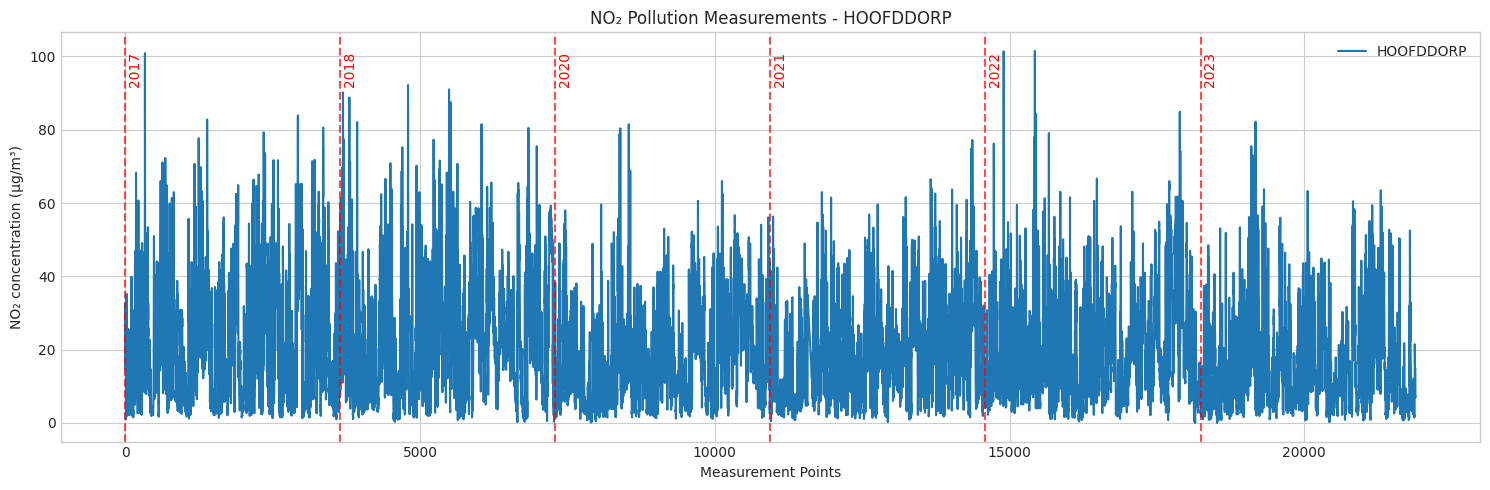

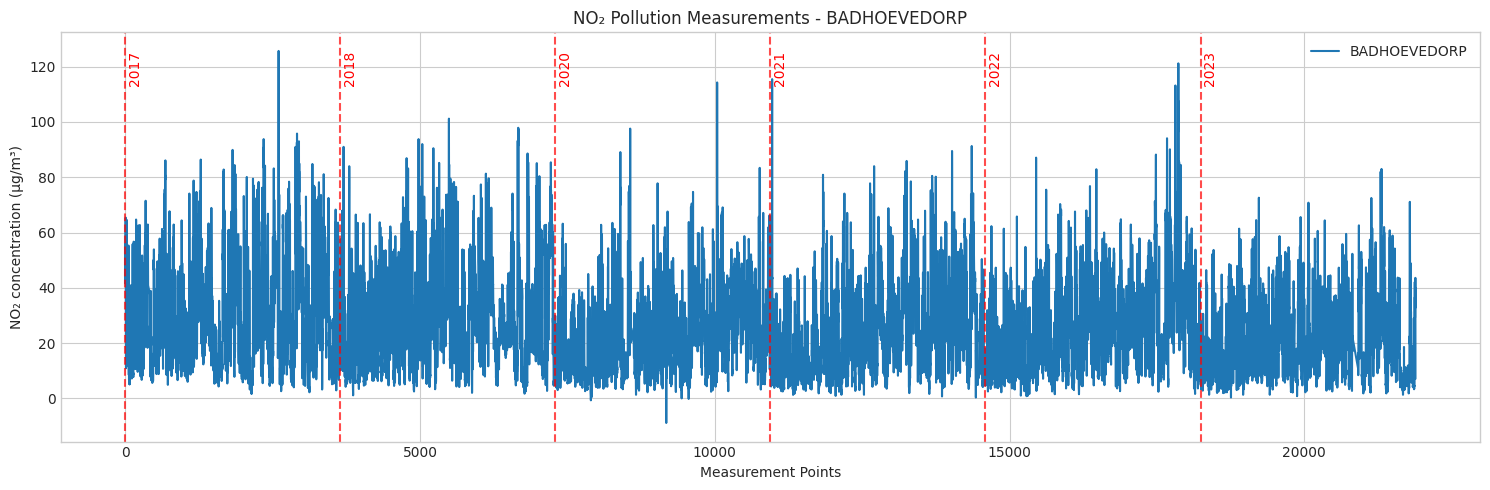

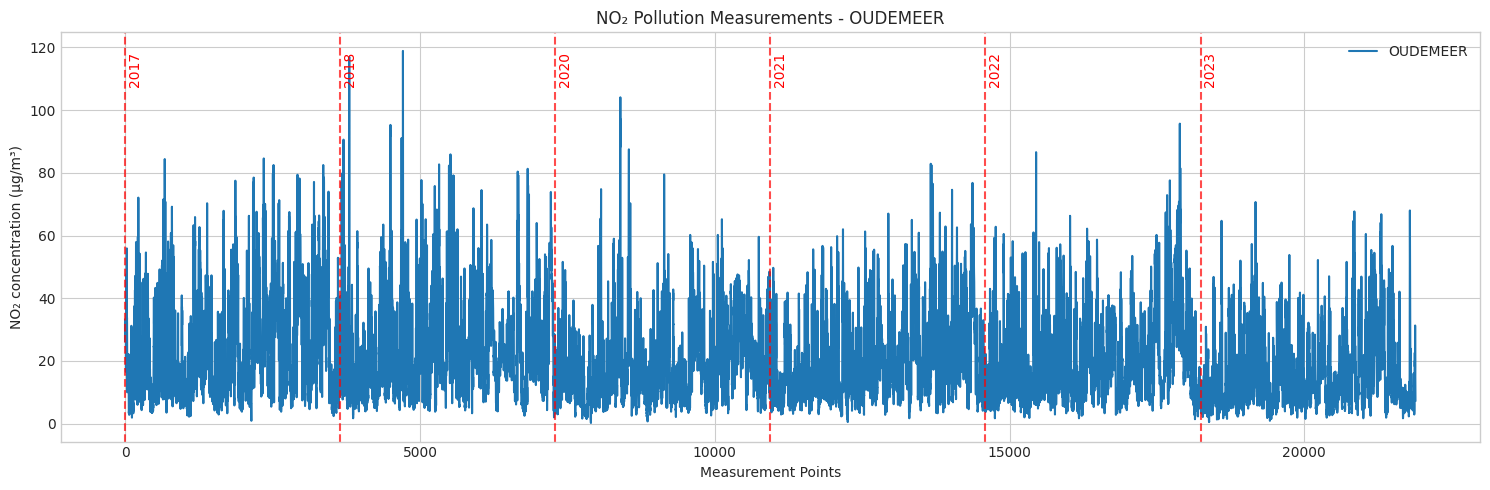

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Define stations
pollution_stations = {
    'HOOFDDORP': 'NL49564',
    'BADHOEVEDORP': 'NL49561',
    'OUDEMEER': 'NL49565'
}


# Collect data
dfs = []
year_start_indices = {}  # To store where each year starts

current_index = 0

for year in years:
    df = globals()[f'df_NO2_{year}_tidy']
    
    if df.index.name != 'DateTime':
        df = df.set_index('DateTime')
    
    df.index = pd.to_datetime(df.index)
    df_selected = df[pollution_stations.values()]
    
    dfs.append(df_selected)
    
    # Record where this year would start on the final x-axis
    year_start_indices[year] = current_index
    current_index += len(df_selected)

# Concatenate all years
df_all_years = pd.concat(dfs)

# Now plot each station separately
for station_name, station_id in pollution_stations.items():
    plt.figure(figsize=(15, 5))
    
    y = df_all_years[station_id].values
    x = np.arange(len(y))  # Just 0, 1, 2, ..., N
    
    plt.plot(x, y, label=station_name, color='tab:blue')
    
    # Add vertical lines and labels for year starts
    for year, idx in year_start_indices.items():
        plt.axvline(x=idx, color='red', linestyle='--', alpha=0.7)
        plt.text(idx + 50, plt.ylim()[1]*0.95, str(year), color='red', rotation=90, verticalalignment='top')
    
    plt.title(f'NO₂ Pollution Measurements - {station_name}')
    plt.xlabel('Measurement Points')
    plt.ylabel('NO₂ concentration (µg/m³)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


## **Extract and tidy meteorological data**

In [20]:
only_DeBilt = True  # True: only De Bilt is used
dataframes = {}

for year in years:
    raw_data = globals()[f'df_meteo_{year}_raw']
    for var in selected_weather:
        var_name = var # if var != 'P' else 'P_'  # Handling 'P' separately to match original naming (removed for now)
        df_name = f"df_{var_name}_{year}_tidy"
        dataframes[df_name] = tidy_raw_meteo_data(
            raw_data, var, only_DeBilt, str(year), SUBSET_MONTHS, START_MON, END_MON)

# Assign variables dynamically
globals().update(dataframes)


In [21]:
# print all the df names of dataframes
for df_name in dataframes:
    print(df_name)


df_T_2017_tidy
df_TD_2017_tidy
df_DD_2017_tidy
df_FH_2017_tidy
df_P_2017_tidy
df_SQ_2017_tidy
df_FF_2017_tidy
df_FX_2017_tidy
df_T_2018_tidy
df_TD_2018_tidy
df_DD_2018_tidy
df_FH_2018_tidy
df_P_2018_tidy
df_SQ_2018_tidy
df_FF_2018_tidy
df_FX_2018_tidy
df_T_2020_tidy
df_TD_2020_tidy
df_DD_2020_tidy
df_FH_2020_tidy
df_P_2020_tidy
df_SQ_2020_tidy
df_FF_2020_tidy
df_FX_2020_tidy
df_T_2021_tidy
df_TD_2021_tidy
df_DD_2021_tidy
df_FH_2021_tidy
df_P_2021_tidy
df_SQ_2021_tidy
df_FF_2021_tidy
df_FX_2021_tidy
df_T_2022_tidy
df_TD_2022_tidy
df_DD_2022_tidy
df_FH_2022_tidy
df_P_2022_tidy
df_SQ_2022_tidy
df_FF_2022_tidy
df_FX_2022_tidy
df_T_2023_tidy
df_TD_2023_tidy
df_DD_2023_tidy
df_FH_2023_tidy
df_P_2023_tidy
df_SQ_2023_tidy
df_FF_2023_tidy
df_FX_2023_tidy


In [22]:
df_T_2017_tidy

,S260
DateTime,
2017-08-01 00:00:00,149.0
2017-08-01 01:00:00,152.0
2017-08-01 02:00:00,140.0
2017-08-01 03:00:00,127.0
2017-08-01 04:00:00,136.0
...,...
2017-12-30 19:00:00,111.0
2017-12-30 20:00:00,108.0
2017-12-30 21:00:00,103.0


In [23]:
# Extract all DataFrames from the dictionary
datasets = list(dataframes.values())

# Ensure there is at least one dataset to check
assert len(datasets) > 0, "Error: No datasets found!"

# 1. Assert all datasets have the same shape
reference_shape = datasets[0].shape  # Take the shape of the first dataset as reference
assert all(df.shape == reference_shape for df in datasets), "Error: Not all datasets have the same shape!"

# 2. Assert no NaNs in any dataset
assert all(not df.isnull().values.any() for df in datasets), "Error: Some datasets contain NaN values!"

print("All datasets have the same shape and contain no NaN values.")
print('(3/8): Meteorological data tidied successfully')


All datasets have the same shape and contain no NaN values.
(3/8): Meteorological data tidied successfully


### **Inspect data with various metrics**

pipeline/statistics.py contains more functions

In [24]:
print("Printing some basic statistics for the pollutants:")
print("(Sensor NL10636 is TUINDORP)\n")

for pollutant in pollutants:
    dataframes = []
    for year in years:
        df_name = f'df_{pollutant}_{year}_tidy'
        try:
            dataframes.append(eval(df_name))
        except NameError:
            print(f"Warning: {df_name} does not exist")
    
    if dataframes:
        meta_name = f'{pollutant}_2017_meta' # meta data is just to know the pollutant name and unit
        print_aggegrated_sensor_metrics(dataframes, TUINDORP, eval(meta_name))


Printing some basic statistics for the pollutants:
(Sensor NL10636 is TUINDORP)

[min, mean, max] for sensor NL10636 measuring NO2 µg/m³
aggregated over multiple years:
[0.7600, 23.3401, 107.4500] with n = 21888



In [25]:
# Delete pollutant data
for year in years:
    for pollutant in pollutants:
        var_name = f"df_{pollutant}_{year}_raw"
        if var_name in globals():
            del globals()[var_name]

# Delete meteorological data
for year in years:
    var_name = f"df_meteo_{year}_raw"
    if var_name in globals():
        del globals()[var_name]


### **Inspect data with visualisations**

plots.py contains plotting functions

### **Select locations**

In [26]:
# Here, we'll select the locations we want to use. The
# generated dataframes will be 1-dimensional
# datasets are called df_pollutant_year_tidy_subset_1D


# Create subset dataframes dynamically
for year in years:
    for pollutant in pollutants:
        raw_var = f"df_{pollutant}_{year}_tidy"
        subset_var = f"{raw_var}_subset_1D"
        
        if raw_var in globals():
            globals()[subset_var] = subset_sensors(globals()[raw_var], sensors_1D)

# Delete original tidy dataframes after subsetting
for year in years:
    for pollutant in pollutants:
        raw_var = f"df_{pollutant}_{year}_tidy"
        if raw_var in globals():
            del globals()[raw_var]


In [27]:
df_NO2_2017_tidy_subset_1D

,NL10636,NL10641
DateTime,,
2017-08-01 00:00:00,23.785,22.08
2017-08-01 01:00:00,22.030,14.84
2017-08-01 02:00:00,16.730,26.92
2017-08-01 03:00:00,14.550,40.60
2017-08-01 04:00:00,15.840,45.69
...,...,...
2017-12-30 19:00:00,17.910,21.44
2017-12-30 20:00:00,14.810,23.19
2017-12-30 21:00:00,20.300,23.58


In [28]:
df_NO2_2018_tidy_subset_1D

,NL10636,NL10641
DateTime,,
2018-08-01 00:00:00,26.35,61.42
2018-08-01 01:00:00,26.95,52.56
2018-08-01 02:00:00,23.10,54.87
2018-08-01 03:00:00,20.10,46.09
2018-08-01 04:00:00,25.97,41.46
...,...,...
2018-12-30 19:00:00,27.28,29.19
2018-12-30 20:00:00,28.16,26.15
2018-12-30 21:00:00,21.26,20.14


Making sure all years and pollutants datasets have the same shapes

In [29]:
for year in years:
    for pollutant in pollutants:
        df_name = f'df_{pollutant}_{year}_tidy_subset_1D'
        try:
            df = eval(df_name)
            print(f"Year: {year}, Pollutant: {pollutant}, Shape: {df.shape}")
        except NameError:
            print(f"Warning: {df_name} does not exist")

Year: 2017, Pollutant: NO2, Shape: (3648, 2)
Year: 2018, Pollutant: NO2, Shape: (3648, 2)
Year: 2020, Pollutant: NO2, Shape: (3648, 2)
Year: 2021, Pollutant: NO2, Shape: (3648, 2)
Year: 2022, Pollutant: NO2, Shape: (3648, 2)
Year: 2023, Pollutant: NO2, Shape: (3648, 2)


### **Perform assertions for pollutant tidy 1D data**

In [30]:
if LOG:
    
    # Collect dataframes dynamically
    shape_check_dfs = [
        globals()[f"df_{pollutant}_{year}_tidy_subset_1D"]
        for year in years
            for pollutant in pollutants
                if f"df_{pollutant}_{year}_tidy_subset_1D" in globals()
    ]

    nan_check_dfs = [
        globals()[f"df_{pollutant}_{year}_tidy_subset_1D"]
        for year in years
            for pollutant in pollutants
                if f"df_{pollutant}_{year}_tidy_subset_1D" in globals()
    ]

    # Perform assertions
    assert_equal_shape(shape_check_dfs, True, True, 'Location-wise subsetting of pollutant data')
    assert_no_NaNs(nan_check_dfs, 'Location-wise subsetting of pollutant data')

    print('(4/8): Location-wise subsetting of pollutant data successful')


(4/8): Location-wise subsetting of pollutant data successful


### **Select timeframe**

Timeframe selection (excluding 2016 and 2019) was done iteratively and manually by inspecting the data and inspecting the distributions. It is discussed in the thesis, Section 3.1, from Valentijn's thesis.

This has already been done in the beginning of the script.


### **Feature Engineering**

This is discussed in Section 3.2 of the thesis and done mainly with a plain correlation matrix.
I'll use the same features that Valentijn has selected from correlation matrix, but add other wind features as well for the PEML model.

### **Finding number of days for validation and test to achirve 75-15-15 splits**

In [31]:
import pandas as pd
# Calculate the total number of days from August 1st to December 30th
# if years are not [2017, 2018, 2020, 2021, 2022, 2023], then days vali and test are calculated manually
# if years are [2017, 2018, 2020, 2021, 2022, 2023], then days vali and test are already defined at the top
if years != [2017, 2018, 2020, 2021, 2022, 2023]:
    print("Assuming start date is August 1st and end date is December 30th in 2017.")
    print("Change accordingly if that's not the case")
    start_date = pd.Timestamp('2017-08-01')
    end_date = pd.Timestamp('2017-12-30')
    total_days = (end_date - start_date).days + 1

    # Calculate 15% of the total number of days for validation and test sets
    days_vali = int(total_days * 0.15)
    days_test = int(total_days * 0.15)
    print(days_vali, days_test)

Assuming start date is August 1st and end date is December 30th in 2017.
Change accordingly if that's not the case
22 22


### **Perform train-validation-test-split**

In [31]:
# Splitting the data according to the years
# According to the splitting defined from Valentijn, 2017 2018 2020 are used for training
# 2021 2022 are used for validation and 2023 is used for testing
if len(years) == 1:
    year = years[0]
    years_splitted = years
    years_unsplitted = []
    year_final = 2023 # if only one year is used, the same year is used for training, validation and testing
    for pollutant in pollutants:
        df_train, df_val, df_test = perform_data_split(eval(f'df_{pollutant}_{year}_tidy_subset_1D'), days_vali, days_test)
        exec(f'df_{pollutant}_{year}_train_1D = df_train')
        exec(f'df_{pollutant}_{year}_val_1D = df_val')
        exec(f'df_{pollutant}_{year}_test_1D = df_test')

    for meteo in selected_weather:
        df_train, df_val, df_test = perform_data_split(eval(f'df_{meteo}_{year}_tidy'), days_vali, days_test)
        exec(f'df_{meteo}_{year}_train = df_train')
        exec(f'df_{meteo}_{year}_val = df_val')
        exec(f'df_{meteo}_{year}_test = df_test')
elif years == [2017, 2018, 2020, 2021, 2022, 2023]:
    years_unsplitted = [2017, 2018, 2020]
    years_splitted = [2021, 2022]
    year_final = 2023
    for year in years:
        if year in years_unsplitted:
            for pollutant in pollutants:
                exec(f'df_{pollutant}_{year}_train_1D = df_{pollutant}_{year}_tidy_subset_1D.copy()')
            for meteo in selected_weather:
                exec(f'df_{meteo}_{year}_train = df_{meteo}_{year}_tidy.copy()')
        elif year in years_splitted:
            for pollutant in pollutants:
                exec(f"df_{pollutant}_{year}_train_1D, df_{pollutant}_{year}_val_1D, df_{pollutant}_{year}_test_1D = "
                    f"perform_data_split(df_{pollutant}_{year}_tidy_subset_1D, days_vali, days_test)")
            for meteo in selected_weather:
                exec(f"df_{meteo}_{year}_train, df_{meteo}_{year}_val, df_{meteo}_{year}_test = "
                    f"perform_data_split(df_{meteo}_{year}_tidy, days_vali, days_test)")
        elif year == year_final:
            for pollutant in pollutants:
                exec(f"df_{pollutant}_{year}_val_1D, df_{pollutant}_{year}_test_1D = "
                    f"perform_data_split_without_train(df_{pollutant}_{year}_tidy_subset_1D, days_vali_final_yrs, days_test_final_yrs)")

            for meteo in selected_weather:
                exec(f"df_{meteo}_{year}_val, df_{meteo}_{year}_test = "
                    f"perform_data_split_without_train(df_{meteo}_{year}_tidy, days_vali_final_yrs, days_test_final_yrs)")

else:
    print("Error: train val test split not defined for the years")

### Checking if shapes are the same for all datasets

In [32]:
if LOG:
     # First, check for equal shape of pollutant data of unsplitted years
    pollutant_data_unsplitted = []
    for year in years_unsplitted:
        if year in years:
            for pollutant in pollutants:
                df_name = f'df_{pollutant}_{year}_train_1D'
                pollutant_data_unsplitted.append(eval(df_name))
    assert_equal_shape(pollutant_data_unsplitted, True, True, 'Split of pollutant train set for 2017, 2018 and 2020')

    # Second, check for equal shape of meteorological data of unsplitted years
    meteorological_data_unsplitted = []
    for year in years_unsplitted:
        if year in years:
            for meteo in selected_weather:
                df_name = f'df_{meteo}_{year}_train'
                meteorological_data_unsplitted.append(eval(df_name))
    assert_equal_shape(meteorological_data_unsplitted, True, True, 'Split of meteorological train set for 2017, 2018 and 2020')

    # Third, check for equal row number of training set in 2021 and 2022
    training_data_splitted = []
    for year in years_splitted:
        if year in years:
            for pollutant in pollutants:
                df_name = f'df_{pollutant}_{year}_train_1D'
                training_data_splitted.append(eval(df_name))
            for meteo in selected_weather:
                df_name = f'df_{meteo}_{year}_train'
                training_data_splitted.append(eval(df_name))
    assert_equal_shape(training_data_splitted, True, False, 'Split of training data for 2021 and 2022')

    # Fourth, check for equal row number of validation set in 2021 and 2022
    validation_data_splitted = []
    for year in years_splitted:
        if year in years:
            for pollutant in pollutants:
                df_name = f'df_{pollutant}_{year}_val_1D'
                validation_data_splitted.append(eval(df_name))
            for meteo in selected_weather:
                df_name = f'df_{meteo}_{year}_val'
                validation_data_splitted.append(eval(df_name))
    assert_equal_shape(validation_data_splitted, True, False, 'Split of validation data for 2021 and 2022')

    # Fifth, check for equal row number of test set in 2021 and 2022
    test_data_splitted = []
    for year in years_splitted:
        if year in years:
            for pollutant in pollutants:
                df_name = f'df_{pollutant}_{year}_test_1D'
                test_data_splitted.append(eval(df_name))
            for meteo in selected_weather:
                df_name = f'df_{meteo}_{year}_test'
                test_data_splitted.append(eval(df_name))
    assert_equal_shape(test_data_splitted, True, False, 'Split of test data for 2021 and 2022')

    # Sixth, check for equal row number of validation set in 2023
    validation_data_final = []
    if year_final in years:
        for pollutant in pollutants:
            df_name = f'df_{pollutant}_{year_final}_val_1D'
            validation_data_final.append(eval(df_name))
        for meteo in selected_weather:
            df_name = f'df_{meteo}_{year_final}_val'
            validation_data_final.append(eval(df_name))
    assert_equal_shape(validation_data_final, True, False, 'Split of validation data for 2023')

    # Seventh, check for equal row number of test set in 2023
    test_data_final = []
    if year_final in years:
        for pollutant in pollutants:
            df_name = f'df_{pollutant}_{year_final}_test_1D'
            test_data_final.append(eval(df_name))
        for meteo in selected_weather:
            df_name = f'df_{meteo}_{year_final}_test'
            test_data_final.append(eval(df_name))
    assert_equal_shape(test_data_final, True, False, 'Split of test data for 2023')

    print('(5/8): Train-validation-test split successful')
    del pollutant_data_unsplitted, meteorological_data_unsplitted, training_data_splitted, validation_data_splitted, test_data_splitted, validation_data_final, test_data_final

(5/8): Train-validation-test split successful


In [34]:
df_NO2_2018_train_1D

,NL10636,NL10641
DateTime,,
2018-08-01 00:00:00,26.35,61.42
2018-08-01 01:00:00,26.95,52.56
2018-08-01 02:00:00,23.10,54.87
2018-08-01 03:00:00,20.10,46.09
2018-08-01 04:00:00,25.97,41.46
...,...,...
2018-12-30 19:00:00,27.28,29.19
2018-12-30 20:00:00,28.16,26.15
2018-12-30 21:00:00,21.26,20.14


In [35]:
df_NO2_2021_test_1D

,NL10636,NL10641
DateTime,,
2021-12-10 00:00:00,15.48,16.78
2021-12-10 01:00:00,14.75,15.41
2021-12-10 02:00:00,9.71,12.67
2021-12-10 03:00:00,6.81,10.04
2021-12-10 04:00:00,7.38,6.01
...,...,...
2021-12-30 19:00:00,9.18,12.25
2021-12-30 20:00:00,10.46,8.57
2021-12-30 21:00:00,8.22,11.28


In [36]:
df_NO2_2021_val_1D

,NL10636,NL10641
DateTime,,
2021-11-19 00:00:00,20.01,26.45
2021-11-19 01:00:00,16.92,23.65
2021-11-19 02:00:00,16.54,22.13
2021-11-19 03:00:00,19.11,18.65
2021-11-19 04:00:00,18.91,17.49
...,...,...
2021-12-09 19:00:00,44.94,47.54
2021-12-09 20:00:00,37.76,44.22
2021-12-09 21:00:00,31.88,34.50


In [37]:
df_NO2_2017_train_1D

,NL10636,NL10641
DateTime,,
2017-08-01 00:00:00,23.785,22.08
2017-08-01 01:00:00,22.030,14.84
2017-08-01 02:00:00,16.730,26.92
2017-08-01 03:00:00,14.550,40.60
2017-08-01 04:00:00,15.840,45.69
...,...,...
2017-12-30 19:00:00,17.910,21.44
2017-12-30 20:00:00,14.810,23.19
2017-12-30 21:00:00,20.300,23.58


### Double checking the train val test split ratio

In [38]:
for pollutant in pollutants:
    train_dfs = []
    val_dfs = []
    test_dfs = []

    for year in years_unsplitted:
        if year in years:
            df_name = f'df_{pollutant}_{year}_train_1D'
            train_dfs.append(eval(df_name))

    for year in years_splitted:
        if year in years:
            train_dfs.append(eval(f'df_{pollutant}_{year}_train_1D'))
            val_dfs.append(eval(f'df_{pollutant}_{year}_val_1D'))
            test_dfs.append(eval(f'df_{pollutant}_{year}_test_1D'))

    if year_final in years:
        val_dfs.append(eval(f'df_{pollutant}_{year_final}_val_1D'))
        test_dfs.append(eval(f'df_{pollutant}_{year_final}_test_1D'))

    print_split_ratios(train_dfs, val_dfs, test_dfs, pollutant)
del train_dfs, val_dfs, test_dfs

[train/validation/test] %-ratio for NO2 data is: [76.3/11.9/11.9]


### **Normalisation**

Warning: make sure the pollutants are parsed in, in order of NO2, O3, PM2.5, PM10

In [39]:
df_NO2_2017_train_1D

,NL10636,NL10641
DateTime,,
2017-08-01 00:00:00,23.785,22.08
2017-08-01 01:00:00,22.030,14.84
2017-08-01 02:00:00,16.730,26.92
2017-08-01 03:00:00,14.550,40.60
2017-08-01 04:00:00,15.840,45.69
...,...,...
2017-12-30 19:00:00,17.910,21.44
2017-12-30 20:00:00,14.810,23.19
2017-12-30 21:00:00,20.300,23.58


In [40]:
years_splitted+years_unsplitted

[2021, 2022, 2017, 2018, 2020]

#### Finding Min Max for pollutants and weather data

In [43]:
# Normalise each component separately, using the training data extremes
years_training = years_unsplitted + years_splitted
import numpy as np
# Calculate min and max parameters for pollutants
pollutant_min_max = {}
for pollutant in pollutants:
    dfs = [eval(f'df_{pollutant}_{year}_train_1D') for year in years_training]
    min_train, max_train = calc_combined_min_max_params(dfs)
    pollutant_min_max[f'{pollutant}_min_train'] = min_train
    pollutant_min_max[f'{pollutant}_max_train'] = max_train

# Calculate min and max parameters for meteorological data
weather_min_max = {}
for meteo in selected_weather:
    dfs = [eval(f'df_{meteo}_{year}_train') for year in years_training]
    min_train, max_train = calc_combined_min_max_params(dfs)
    weather_min_max[f'{meteo}_min_train'] = min_train
    weather_min_max[f'{meteo}_max_train'] = max_train

# Print pollutant extremes
print()
df_minmax = print_pollutant_extremes(
    [pollutant_min_max[f'{pollutant}_min_train'] for pollutant in pollutants] +
    [pollutant_min_max[f'{pollutant}_max_train'] for pollutant in pollutants],
    pollutants
)
print()

# # Export min and max parameters
if years == [2017]:
    export_minmax(df_minmax, 'only_2017/pollutants_minmax_2017')
elif years == [2017, 2018, 2020, 2021, 2022, 2023]:
    export_minmax(df_minmax, 'all_years/pollutants_minmax_allyears')
else:
    print("Error: Min and max parameters not exported")


      min     max
NO2 -0.28  107.45



### Normalising according to min max

In [44]:
# Normalise each component separately, using the training data extremes

print("------Normalising the pollutants------")
for pollutant in pollutants:
    print(f"Normalising {pollutant}...")
    min_train = pollutant_min_max[f'{pollutant}_min_train']
    max_train = pollutant_min_max[f'{pollutant}_max_train']
    for year in years:
        for split in ['train_1D', 'val_1D', 'test_1D']:
            df_name = f'df_{pollutant}_{year}_{split}'
            norm_df_name = f'df_{pollutant}_{year}_{split}_norm'
            try:
                df = eval(df_name)
                norm_df = normalise_linear(df, min_train, max_train)
                globals()[norm_df_name] = norm_df
                print(f"Normalised {df_name}")
            except NameError:
                print(f"Warning: {df_name} does not exist.")

print("-------Normalising the weather data-------")
for meteo in selected_weather:
    print(f"Normalising {meteo}...")
    min_train = weather_min_max[f'{meteo}_min_train']
    max_train = weather_min_max[f'{meteo}_max_train']
    for year in years:
        for split in ['train', 'val', 'test']:
            df_name = f'df_{meteo}_{year}_{split}'
            norm_df_name = f'df_{meteo}_{year}_{split}_norm'
            try:
                df = eval(df_name)
                norm_df = normalise_linear(df, min_train, max_train)
                globals()[norm_df_name] = norm_df
                print(f"Normalised {df_name}")
            except NameError:
                print(f"Warning: {df_name} does not exist.")

------Normalising the pollutants------
Normalising NO2...
Normalised df_NO2_2017_train_1D
Normalised df_NO2_2018_train_1D
Normalised df_NO2_2020_train_1D
Normalised df_NO2_2021_train_1D
Normalised df_NO2_2021_val_1D
Normalised df_NO2_2021_test_1D
Normalised df_NO2_2022_train_1D
Normalised df_NO2_2022_val_1D
Normalised df_NO2_2022_test_1D
Normalised df_NO2_2023_val_1D
Normalised df_NO2_2023_test_1D
-------Normalising the weather data-------
Normalising T...
Normalised df_T_2017_train
Normalised df_T_2018_train
Normalised df_T_2020_train
Normalised df_T_2021_train
Normalised df_T_2021_val
Normalised df_T_2021_test
Normalised df_T_2022_train
Normalised df_T_2022_val
Normalised df_T_2022_test
Normalised df_T_2023_val
Normalised df_T_2023_test
Normalising TD...
Normalised df_TD_2017_train
Normalised df_TD_2018_train
Normalised df_TD_2020_train
Normalised df_TD_2021_train
Normalised df_TD_2021_val
Normalised df_TD_2021_test
Normalised df_TD_2022_train
Normalised df_TD_2022_val
Normalised df_

In [45]:
if LOG:
    # Assert range only for training frames, validation and test
    # frames can, very theoretically, have unlimited values
    for pollutant in pollutants:
        train_dfs = []
        for year in years:
            df_name = f'df_{pollutant}_{year}_train_norm_1D'
            try:
                df = eval(df_name)
                train_dfs.append(df)
            except NameError:
                pass
        assert_range(train_dfs, 0, 1, f'Normalisation of {pollutant} data')

    for meteo in selected_weather:
        train_dfs = []
        for year in years:

            df_name = f'df_{meteo}_{year}_train_norm'
            try:
                df = eval(df_name)
                train_dfs.append(df)
            except NameError:
                pass
        assert_range(train_dfs, 0, 1, f'Normalisation of {meteo} data')

    print('(6/8): Normalisation successful')

(6/8): Normalisation successful


In [46]:
df_FX_2021_val_norm

,S260
DateTime,
2021-11-19 00:00:00,0.304348
2021-11-19 01:00:00,0.304348
2021-11-19 02:00:00,0.304348
2021-11-19 03:00:00,0.347826
2021-11-19 04:00:00,0.260870
...,...
2021-12-09 19:00:00,0.260870
2021-12-09 20:00:00,0.217391
2021-12-09 21:00:00,0.391304


In [48]:
df_NO2_2021_train_1D_norm

,NL10636,NL10641
DateTime,,
2021-08-01 00:00:00,0.152975,0.235310
2021-08-01 01:00:00,0.134689,0.171540
2021-08-01 02:00:00,0.121786,0.143971
2021-08-01 03:00:00,0.111482,0.130883
2021-08-01 04:00:00,0.104335,0.130511
...,...,...
2021-11-18 19:00:00,0.339738,0.299452
2021-11-18 20:00:00,0.286828,0.288870
2021-11-18 21:00:00,0.288221,0.284693


### **Create big combined normalised dataframe**

#### Creating all the input dataframes with data from Tuindorp

In [50]:
# Create a dictionary to store the frames for each year and split
frames_dict_u = {}

splits = ['train', 'val', 'test']

# Loop through each year and split to create the combined normalized dataframes
for year in years:
    frames_dict_u[year] = {}
    for split in splits:
        frames_dict_u[year][split] = {}
        for pollutant in pollutants:
            df_name = f'df_{pollutant}_{year}_{split}_1D_norm'
            try:
                df = eval(df_name)
                
                # Rename columns dynamically
                df = df.rename(columns={TUINDORP: f"{pollutant}_TUINDORP", 
                                        BREUKELEN: f"{pollutant}_BREUKELEN"})
                
                frames_dict_u[year][split][pollutant] = df
                print(f"frame dict added {pollutant}_{split}_{year}")
            except NameError:
                print(f"Warning: {df_name} does not exist.")
        for meteo in selected_weather:
            df_name = f'df_{meteo}_{year}_{split}_norm'
            try:
                df = eval(df_name)
                frames_dict_u[year][split][meteo] = df
            except NameError:
                print(f"Warning: {df_name} does not exist.")

# Print all the names of frames in frames_dict_u
print("Frames in frames_dict_u:")
for year in frames_dict_u:
    for split in frames_dict_u[year]:
        for key in frames_dict_u[year][split]:
            print(f"{key}_{split}_{year}")

# Example of accessing specific frames
print(frames_dict_u[2017]['train']['NO2'])
print("---------------")
print(frames_dict_u[2021]['val']['T'])

frame dict added NO2_train_2017
frame dict added NO2_train_2018
frame dict added NO2_train_2020
frame dict added NO2_train_2021
frame dict added NO2_val_2021
frame dict added NO2_test_2021
frame dict added NO2_train_2022
frame dict added NO2_val_2022
frame dict added NO2_test_2022
frame dict added NO2_val_2023
frame dict added NO2_test_2023
Frames in frames_dict_u:
NO2_train_2017
T_train_2017
TD_train_2017
DD_train_2017
FH_train_2017
P_train_2017
SQ_train_2017
FF_train_2017
FX_train_2017
NO2_train_2018
T_train_2018
TD_train_2018
DD_train_2018
FH_train_2018
P_train_2018
SQ_train_2018
FF_train_2018
FX_train_2018
NO2_train_2020
T_train_2020
TD_train_2020
DD_train_2020
FH_train_2020
P_train_2020
SQ_train_2020
FF_train_2020
FX_train_2020
NO2_train_2021
T_train_2021
TD_train_2021
DD_train_2021
FH_train_2021
P_train_2021
SQ_train_2021
FF_train_2021
FX_train_2021
NO2_val_2021
T_val_2021
TD_val_2021
DD_val_2021
FH_val_2021
P_val_2021
SQ_val_2021
FF_val_2021
FX_val_2021
NO2_test_2021
T_test_2021

In [51]:
frames_dict_u[2017]['train']['DD']

,S260
DateTime,
2017-08-01 00:00:00,0.166667
2017-08-01 01:00:00,0.000000
2017-08-01 02:00:00,0.000000
2017-08-01 03:00:00,0.277778
2017-08-01 04:00:00,0.805556
...,...
2017-12-30 19:00:00,0.694444
2017-12-30 20:00:00,0.694444
2017-12-30 21:00:00,0.666667


#### Creating all the input dataframes with data from Breukelen

In [53]:
# Create a dictionary to store the frames for each year and split
frames_dict_y = {}

# Loop through each year and split to create the combined normalized dataframes for Breukelen
for year in years:
    frames_dict_y[year] = {}
    for split in splits:
        frames_dict_y[year][split] = {}
        for pollutant in pollutants:
            df_name = f'df_{pollutant}_{year}_{split}_1D_norm'
            try:
                df = eval(df_name)
                frames_dict_y[year][split][pollutant] = df.loc[:, [BREUKELEN]]
                print(f"frame dict added {pollutant}_{split}_{year} for Breukelen")
            except NameError:
                print(f"Warning: {df_name} does not exist.")
# Print all the names of frames in frames_dict_y
print("Frames in frames_dict_y:")
for year in frames_dict_y:
    for split in frames_dict_y[year]:
        for key in frames_dict_y[year][split]:
            print(f"{key}_{split}_{year}")

# Example of accessing specific frames
print(frames_dict_y[2017]['train']['NO2'])
print(frames_dict_y[2021]['val']['NO2'])



frame dict added NO2_train_2017 for Breukelen
frame dict added NO2_train_2018 for Breukelen
frame dict added NO2_train_2020 for Breukelen
frame dict added NO2_train_2021 for Breukelen
frame dict added NO2_val_2021 for Breukelen
frame dict added NO2_test_2021 for Breukelen
frame dict added NO2_train_2022 for Breukelen
frame dict added NO2_val_2022 for Breukelen
frame dict added NO2_test_2022 for Breukelen
frame dict added NO2_val_2023 for Breukelen
frame dict added NO2_test_2023 for Breukelen
Frames in frames_dict_y:
NO2_train_2017
NO2_train_2018
NO2_train_2020
NO2_train_2021
NO2_val_2021
NO2_test_2021
NO2_train_2022
NO2_val_2022
NO2_test_2022
NO2_val_2023
NO2_test_2023
                      NL10641
DateTime                     
2017-08-01 00:00:00  0.207556
2017-08-01 01:00:00  0.140351
2017-08-01 02:00:00  0.252483
2017-08-01 03:00:00  0.379467
2017-08-01 04:00:00  0.426715
...                       ...
2017-12-30 19:00:00  0.201615
2017-12-30 20:00:00  0.217859
2017-12-30 21:00:00  0

In [54]:
input_keys = []
for pollutant in pollutants:
    input_keys.append(f"{pollutant}_TUINDORP")
    input_keys.append(f"{pollutant}_BREUKELEN")
    input_keys+=selected_weather
input_keys

['NO2_TUINDORP', 'NO2_BREUKELEN', 'T', 'TD', 'DD', 'FH', 'P', 'SQ', 'FF', 'FX']

In [55]:
output_keys = pollutants
output_keys

['NO2']

In [56]:
frames_dict_u[2017]['train']['NO2']

,NO2_TUINDORP,NO2_BREUKELEN
DateTime,,
2017-08-01 00:00:00,0.223383,0.207556
2017-08-01 01:00:00,0.207092,0.140351
2017-08-01 02:00:00,0.157895,0.252483
2017-08-01 03:00:00,0.137659,0.379467
2017-08-01 04:00:00,0.149633,0.426715
...,...,...
2017-12-30 19:00:00,0.168848,0.201615
2017-12-30 20:00:00,0.140072,0.217859
2017-12-30 21:00:00,0.191033,0.221480


In [ ]:
for year, splits in frames_dict_u.items():
    for split, keys in splits.items():
        if 'NO2' in keys:
            no2_df = keys['NO2']
            # Split the 'no2' dataframe into separate keys
            for col in no2_df.columns:
                new_key = col  # Extract the city name (e.g., 'breukelen' or 'tuindorp')
                frames_dict_u[year][split][new_key] = no2_df[[col]]  # Add as a new key
            del frames_dict_u[year][split]['NO2']  # Remove the original 'no2' key
frames_dict_u[2017]['train']['NO2_BREUKELEN']

,NO2_BREUKELEN
DateTime,
2017-08-01 00:00:00,0.207556
2017-08-01 01:00:00,0.140351
2017-08-01 02:00:00,0.252483
2017-08-01 03:00:00,0.379467
2017-08-01 04:00:00,0.426715
...,...
2017-12-30 19:00:00,0.201615
2017-12-30 20:00:00,0.217859
2017-12-30 21:00:00,0.221480


In [60]:
frames_dict_u[2021]['val']['NO2_TUINDORP']

,NO2_TUINDORP
DateTime,
2021-11-19 00:00:00,0.188341
2021-11-19 01:00:00,0.159658
2021-11-19 02:00:00,0.156131
2021-11-19 03:00:00,0.179987
2021-11-19 04:00:00,0.178131
...,...
2021-12-09 19:00:00,0.419753
2021-12-09 20:00:00,0.353105
2021-12-09 21:00:00,0.298524


### Concatenating and putting the keys in alpha order

In [61]:
# Create dictionaries to store the concatenated dataframes for each year and split
concat_frames_dict_u = {}
concat_frames_dict_y = {}


# Loop through each year and split to concatenate the frames horizontally for Tuindorp
for year in years:
    concat_frames_dict_u[year] = {}
    for split in splits:
        frames = []
        for key in input_keys:
            
            try:
                frames.append(frames_dict_u[year][split][key])
            except KeyError:
                print(f"Warning: {key}_{split}_{year} does not exist.")
        if frames:
            concat_frames_dict_u[year][split] = concat_frames_horizontally(frames, input_keys)
        else:
            print(f"No frames found for {split} {year} for Tuindorp")
        print(f"Concatenated Input frames for {split} {year} for Tuindorp")

# Loop through each year and split to concatenate the frames horizontally for Breukelen
for year in years:
    concat_frames_dict_y[year] = {}
    for split in splits:
        frames = []
        for key in output_keys:
            try:
                frames.append(frames_dict_y[year][split][key])
            except KeyError:
                print(f"Warning: {key}_{split}_{year} does not exist.")
        if frames:
            concat_frames_dict_y[year][split] = concat_frames_horizontally(frames, output_keys)
        else:
            print(f"No frames found for {split} {year} for Breukelen")
        print(f"Concatenated Output frames for {split} {year} for Breukelen")


component NO2_TUINDORP
component NO2_BREUKELEN
component T
component TD
component DD
component FH
component P
component SQ
component FF
component FX
before {'NO2_TUINDORP':                      NO2_TUINDORP
DateTime                         
2017-08-01 00:00:00      0.223383
2017-08-01 01:00:00      0.207092
2017-08-01 02:00:00      0.157895
2017-08-01 03:00:00      0.137659
2017-08-01 04:00:00      0.149633
...                           ...
2017-12-30 19:00:00      0.168848
2017-12-30 20:00:00      0.140072
2017-12-30 21:00:00      0.191033
2017-12-30 22:00:00      0.147406
2017-12-30 23:00:00      0.158823

[3648 rows x 1 columns], 'NO2_BREUKELEN':                      NO2_BREUKELEN
DateTime                          
2017-08-01 00:00:00       0.207556
2017-08-01 01:00:00       0.140351
2017-08-01 02:00:00       0.252483
2017-08-01 03:00:00       0.379467
2017-08-01 04:00:00       0.426715
...                            ...
2017-12-30 19:00:00       0.201615
2017-12-30 20:00:00       0

In [62]:

# Example of accessing specific concatenated frames
print(concat_frames_dict_u[2017]['train'])


                           DD        FF        FH        FX  NO2_BREUKELEN  \
DateTime                                                                     
2017-08-01 00:00:00  0.166667  0.083333  0.083333  0.043478       0.207556   
2017-08-01 01:00:00  0.000000  0.000000  0.083333  0.086957       0.140351   
2017-08-01 02:00:00  0.000000  0.000000  0.000000  0.043478       0.252483   
2017-08-01 03:00:00  0.277778  0.083333  0.000000  0.043478       0.379467   
2017-08-01 04:00:00  0.805556  0.166667  0.083333  0.130435       0.426715   
...                       ...       ...       ...       ...            ...   
2017-12-30 19:00:00  0.694444  0.416667  0.416667  0.478261       0.201615   
2017-12-30 20:00:00  0.694444  0.416667  0.333333  0.434783       0.217859   
2017-12-30 21:00:00  0.666667  0.333333  0.416667  0.434783       0.221480   
2017-12-30 22:00:00  0.694444  0.250000  0.250000  0.304348       0.209505   
2017-12-30 23:00:00  0.666667  0.416667  0.250000  0.304348     

In [63]:

# Example of accessing specific concatenated frames

print(concat_frames_dict_y[2017]['train'])

                          NO2
DateTime                     
2017-08-01 00:00:00  0.207556
2017-08-01 01:00:00  0.140351
2017-08-01 02:00:00  0.252483
2017-08-01 03:00:00  0.379467
2017-08-01 04:00:00  0.426715
...                       ...
2017-12-30 19:00:00  0.201615
2017-12-30 20:00:00  0.217859
2017-12-30 21:00:00  0.221480
2017-12-30 22:00:00  0.209505
2017-12-30 23:00:00  0.240787

[3648 rows x 1 columns]


In [64]:
# At last, a final check before exporting

if LOG:
    if years == [2017, 2018, 2020, 2021, 2022, 2023]:
        # Define the years for unsplitted and splitted data
        years_unsplitted = [2017, 2018, 2020]
        years_splitted = [2021, 2022]

        # First, check if u-dataframes of unsplitted years have the same shape
        u_data_unsplitted = [concat_frames_dict_u[year]['train'] for year in years_unsplitted]
        assert_equal_shape(u_data_unsplitted, True, True, 'Shape of u-dataframes of unsplitted years')

        # Second, check if y-dataframes of unsplitted years have the same shape
        y_data_unsplitted = [concat_frames_dict_y[year]['train'] for year in years_unsplitted]
        assert_equal_shape(y_data_unsplitted, True, True, 'Shape of y-dataframes of unsplitted years')

        # Third, check if validation/test u-dataframes of splitted years have the same shape
        u_data_splitted = [concat_frames_dict_u[year][split] for year in years_splitted for split in ['val', 'test']]
        assert_equal_shape(u_data_splitted, True, True, 'Shape of u-dataframes of splitted years')

        # Fourth, check if validation/test y-dataframes of splitted years have the same shape
        y_data_splitted = [concat_frames_dict_y[year][split] for year in years_splitted for split in ['val', 'test']]
        assert_equal_shape(y_data_splitted, True, True, 'Shape of y-dataframes of splitted years')

        print('(7/8): All data concatenations successful for years 2017, 2018, 2020, 2021, 2022')
    elif len(years) == 1:
        # print the shape of the concat frames for that year, for all train, val and test
        for split in splits:
            print(f"Shape of concatenated frames for {split} {years[0]}:")
            print(concat_frames_dict_u[years[0]][split].shape)
            print(concat_frames_dict_y[years[0]][split].shape)
        print('(7/8): All data concatenations successful for years 2017, 2018, 2020, 2021, 2022')
    else:
        print("Error: Data concatenation not defined for the specific years")


(7/8): All data concatenations successful for years 2017, 2018, 2020, 2021, 2022


In [65]:
concat_frames_dict_u[2017]['train']

,DD,FF,FH,FX,NO2_BREUKELEN,NO2_TUINDORP,P,SQ,T,TD
DateTime,,,,,,,,,,
2017-08-01 00:00:00,0.166667,0.083333,0.083333,0.043478,0.207556,0.223383,0.634943,0.0,0.497354,0.723022
2017-08-01 01:00:00,0.000000,0.000000,0.083333,0.086957,0.140351,0.207092,0.639205,0.0,0.505291,0.733813
2017-08-01 02:00:00,0.000000,0.000000,0.000000,0.043478,0.252483,0.157895,0.633523,0.0,0.473545,0.694245
2017-08-01 03:00:00,0.277778,0.083333,0.000000,0.043478,0.379467,0.137659,0.630682,0.0,0.439153,0.651079
2017-08-01 04:00:00,0.805556,0.166667,0.083333,0.130435,0.426715,0.149633,0.630682,0.0,0.462963,0.672662
...,...,...,...,...,...,...,...,...,...,...
2017-12-30 19:00:00,0.694444,0.416667,0.416667,0.478261,0.201615,0.168848,0.457386,0.0,0.396825,0.507194
2017-12-30 20:00:00,0.694444,0.416667,0.333333,0.434783,0.217859,0.140072,0.471591,0.0,0.388889,0.496403
2017-12-30 21:00:00,0.666667,0.333333,0.416667,0.434783,0.221480,0.191033,0.473011,0.0,0.375661,0.503597


In [66]:
# Save the dataframes to data_combined/ folder. The windowing will be performed
# by a PyTorch Dataset class in the model scripts.

# Loop through each year and split to save the concatenated dataframes for Tuindorp
if years == [2017, 2018, 2020, 2021, 2022, 2023]:
    folder = 'all_years'
elif years == [2017]:
    folder = 'only_2017'
else:
    folder = 'unknown_years'

for year in years:
    for split in splits:
        try:
            df = concat_frames_dict_u[year][split]
            # Ensure all NO2, PM10, etc., are uniquely named for each city
            # df = df.rename(columns=lambda col: f"{col}_TUINDORP" if col in pollutants else col)
            # df = df.rename(columns=lambda col: f"{col}_BREUKELEN" if col in pollutants else col)

            df.to_csv(f"../data/data_combined/{folder}/{split}_{year}_combined_u.csv",
                      index=True, sep=';', decimal='.', encoding='utf-8')
            print(f"Saved {split}_{year}_combined_u.csv")
        except KeyError:
            print(f"Warning: {split}_{year}_combined_u does not exist.")

# Loop through each year and split to save the concatenated dataframes for Breukelen
for year in years:
    for split in splits:
        try:
            df = concat_frames_dict_y[year][split]
            df.to_csv(f"../data/data_combined/{folder}/{split}_{year}_combined_y.csv",
                      index=True, sep=';', decimal='.', encoding='utf-8')
            print(f"Saved {split}_{year}_combined_y.csv")
        except KeyError:
            print(f"Warning: {split}_{year}_combined_y does not exist.")

Saved train_2017_combined_u.csv
Saved train_2018_combined_u.csv
Saved train_2020_combined_u.csv
Saved train_2021_combined_u.csv
Saved val_2021_combined_u.csv
Saved test_2021_combined_u.csv
Saved train_2022_combined_u.csv
Saved val_2022_combined_u.csv
Saved test_2022_combined_u.csv
Saved val_2023_combined_u.csv
Saved test_2023_combined_u.csv
Saved train_2017_combined_y.csv
Saved train_2018_combined_y.csv
Saved train_2020_combined_y.csv
Saved train_2021_combined_y.csv
Saved val_2021_combined_y.csv
Saved test_2021_combined_y.csv
Saved train_2022_combined_y.csv
Saved val_2022_combined_y.csv
Saved test_2022_combined_y.csv
Saved val_2023_combined_y.csv
Saved test_2023_combined_y.csv


In [67]:
if LOG:
    print('(8/8): Data exported successfully')
    print('Data preparation finished')

(8/8): Data exported successfully
Data preparation finished
